# QuantumBlack Hackathon - AI For Good

Binary classifier that predicts presence of methane emissions in an image. Model integrated in a Streamlit Web App for seamless workflows.

***
by: Clara Besnard, Ian Moon, Marina Pellet, Łukasz Pszenny, Adel Remadi, Lasse Schmidt

within: MS Data Sciences & Business Analytics

at: CentraleSupélec & ESSEC Business School
***

This notebook covers an initial analysis of the provided data (metadata of images as well as images themselves).

In [ ]:
# if necessary, run installs
%pip install os pandas geopandas shapely reverse_geocoder pycountry

### 1. Import Packages

In [1]:
# data handling
import pandas as pd
import numpy as np

# geodata
import geopandas as gpd
from shapely.geometry import Point
import reverse_geocoder as rg
import pycountry

# data viz
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
# set matplotlib and seaborn settings for nicer plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### 2. Load Data

In [3]:
metadata = pd.read_csv("images/metadata.csv")
metadata.head(2)

,date,id_coord,plume,set,lat,lon,coord_x,coord_y,path
0,20230223,id_6675,yes,train,31.52875,74.330625,24,47,images/plume/20230223_methane_mixing_ratio_id_...
1,20230103,id_2542,yes,train,35.53800,112.524000,42,37,images/plume/20230103_methane_mixing_ratio_id_...


In [4]:
len(metadata)

430

Overall, we only have 430 available images. Transfer learning might be a very promising approach.

Let us now have a look at the countries that are represented in this dataset.

In [5]:
# Create a new column called 'geometry' that creates Point objects from the lat and lon columns
metadata["geometry"] = metadata.apply(lambda row: Point(row.lon, row.lat), axis=1)

# Convert the dataframe to a GeoDataFrame
gdf = gpd.GeoDataFrame(metadata, geometry="geometry", crs = "EPSG:4326")

In [6]:
# Use reverse_geocoder to get the city and country information
coords = list(zip(gdf["lat"], gdf["lon"]))
results = rg.search(coords)

# Extract city and country and add to the dataframe
gdf["city"] = [r["name"] for r in results]
gdf["country_code"] = [r["cc"] for r in results]

# Convert country codes to country names
def get_country_name(country_code):
    try:
        return pycountry.countries.get(alpha_2=country_code).name
    except AttributeError:
        return None
    
gdf["country"] = gdf["country_code"].apply(get_country_name)

# show dataframe
gdf.head(2)

Loading formatted geocoded file...


,date,id_coord,plume,set,lat,lon,coord_x,coord_y,path,geometry,city,country_code,country
0,20230223,id_6675,yes,train,31.52875,74.330625,24,47,images/plume/20230223_methane_mixing_ratio_id_...,POINT (74.33062 31.52875),Lahore,PK,Pakistan
1,20230103,id_2542,yes,train,35.53800,112.524000,42,37,images/plume/20230103_methane_mixing_ratio_id_...,POINT (112.52400 35.53800),Fengcheng,CN,China


In [38]:
# Define a function to count the number of images with plumes
def count_with_plumes(x):
    return x[x == 'yes'].count()

# Define a function to count the number of images without plumes
def count_without_plumes(x):
    return x[x == 'no'].count()

# Group by 'country' and apply the aggregate functions
result = gdf.groupby('country').agg(
    images_with_plumes=pd.NamedAgg(column='plume', aggfunc=count_with_plumes),
    images_without_plumes=pd.NamedAgg(column='plume', aggfunc=count_without_plumes),
    Total=pd.NamedAgg(column='path', aggfunc='count'),
)

# Sort the result in descending order by total_images
result = (result
    .sort_values(by='Total', ascending=False)
    .rename(columns = {"images_with_plumes": "Yes", "images_without_plumes": "No"})
)

# Get the top 10 countries
top_10 = result.head(10)

# Get the other countries
other_countries = result.iloc[10:]

# Calculate the statistics for the other countries
other_stats = other_countries.sum()
other_stats.name = f"({len(result.iloc[10:].index.unique())} Countries)"

# Append the statistics for the other countries to the top 10 countries
result_with_other = top_10.append(other_stats)

# reset index
result_with_other.reset_index(inplace = True)

# Define the rank values
ranks = list(range(1, 11)) + ['Rest']

# Assign the ranks as the new index
result_with_other.index = ranks

# Show dataframe
result_with_other

C:\Users\lasse\AppData\Local\Temp\ipykernel_21276\1650005248.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  result_with_other = top_10.append(other_stats)


,country,Yes,No,Total
1,India,97,0,97
2,Syrian Arab Republic,4,54,58
3,Iraq,0,37,37
4,Bangladesh,27,0,27
5,"Korea, Republic of",0,21,21
6,Jordan,0,21,21
7,Pakistan,17,0,17
8,Turkmenistan,16,0,16
9,Russian Federation,8,7,15
10,United States,12,0,12


In [41]:
gdf.id_coord.value_counts()

id_6707    21
id_5510    19
id_3773    18
id_2274    17
id_4574    15
           ..
id_8815     1
id_3201     1
id_7352     1
id_4187     1
id_2519     1
Name: id_coord, Length: 101, dtype: int64

In [8]:
# Write dataframe to map
map = gdf.explore("plume", tiles = "CartoDB positron", cmap = "RdYlGn_r")

# Save map
map.save(outfile= "maps/dataset_overview.html")
    
# Show map
map

In [48]:
# update pandas column width settings
pd.set_option("display.max_colwidth", 30)

# example of datapoint
sample_datapoint = (gdf[["set", "coord_x", "coord_y", "id_coord", "lat", "lon", "city", "country", "country_code",
                         "path", "plume", "date"]]
    .loc[71].transpose().reset_index()
    .rename(columns = {"index": "feature name", 71: "values"})
)

col_dtypes = pd.Series(["categorical", "numerical", "numerical",
                        "geographical", "geographical", "geographical", "geographical", "geographical", "geographical",
                        "string", "target", "categorical"])

sample_datapoint.insert(0, "data type", col_dtypes)

sample_datapoint.groupby(["data type", "feature name"]).sum()

values
data type    feature name                               
categorical  date                               20230307
             set                                   train
geographical city                                  Kahna
             country                            Pakistan
             country_code                             PK
             id_coord                            id_8701
             lat                               31.443333
             lon                               74.316667
numerical    coord_x                                  26
             coord_y                                  47
string       path          images/plume/20230307_meth...
target       plume                                   yes

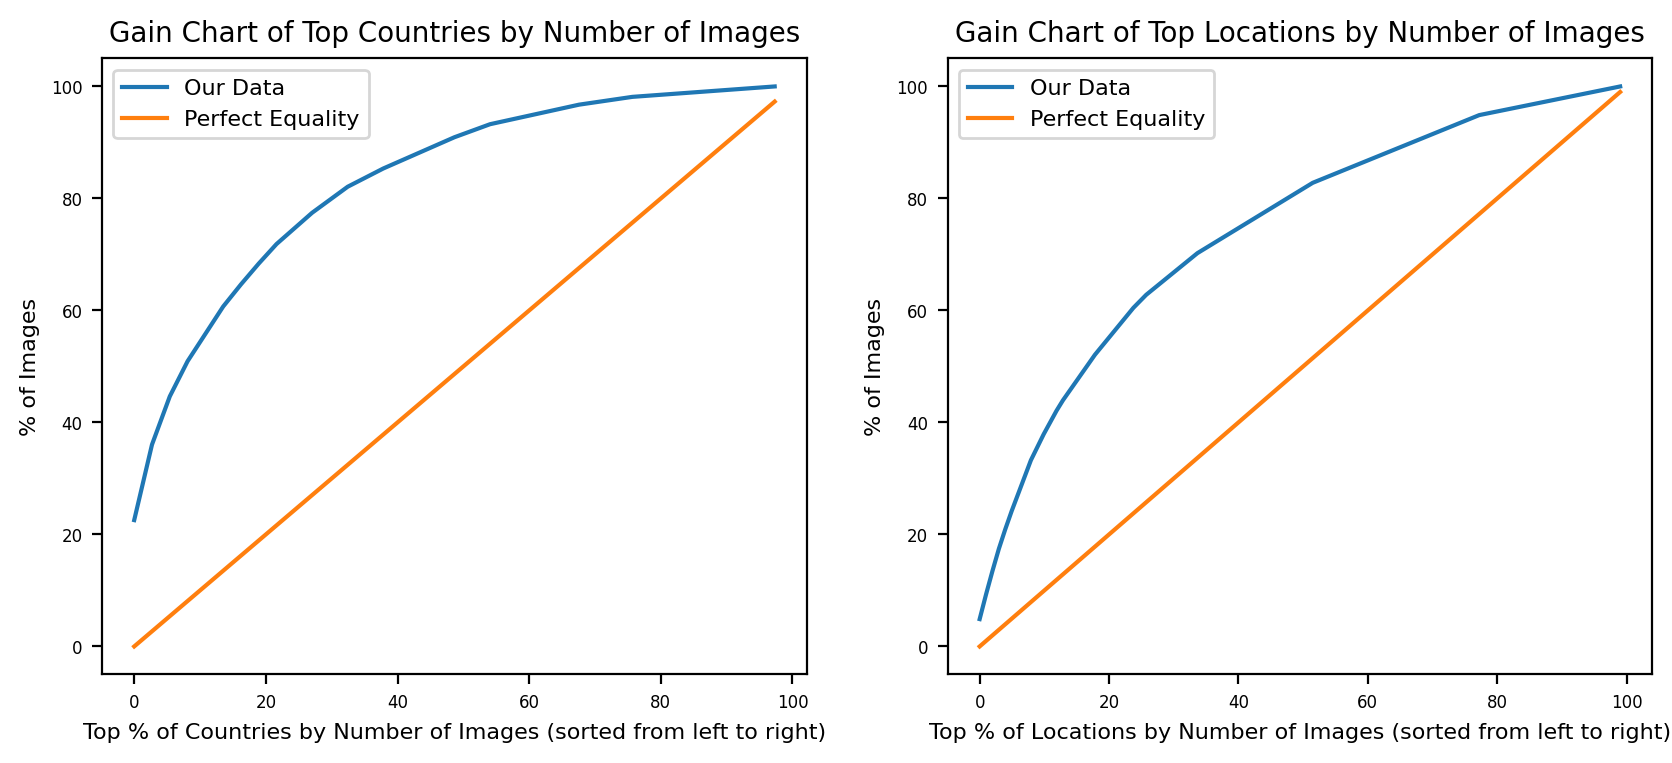

In [13]:
# plot gain chart of number of images by (1) country, (2) id_coord
fig, ax = plt.subplots(1, 2, figsize = (10, 4))

## (1) by countries

## image count by country
images_by_country = np.cumsum(gdf.country.value_counts().values)
x = [(i / len(images_by_country)) * 100 for i in range(0, len(images_by_country))]

## plot data
ax[0].plot(x, images_by_country / len(gdf) * 100, label = "Our Data")
ax[0].plot(x, x, label = "Perfect Equality")
ax[0].set_title("Gain Chart of Top Countries by Number of Images")
ax[0].set_xlabel("Top % of Countries by Number of Images (sorted from left to right)")
ax[0].set_ylabel("% of Images")
ax[0].legend()

## (1) by id_coord

## image count by id_coord
images_by_id = np.cumsum(gdf.id_coord.value_counts().values)
x = [(i / len(images_by_id)) * 100 for i in range(0, len(images_by_id))]

## plot data
ax[1].plot(x, images_by_id / len(gdf) * 100, label = "Our Data")
ax[1].plot(x, x, label = "Perfect Equality")
ax[1].set_title("Gain Chart of Top Locations by Number of Images")
ax[1].set_xlabel("Top % of Locations by Number of Images (sorted from left to right)")
ax[1].set_ylabel("% of Images")
ax[1].legend()